#Notebook for experiments on BigGAN generator

# Installing BIGGAN

In [ ]:
#google drive prefixes
imagenet_path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/imagenet"
path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/"

In [ ]:
!pip install pytorch-pretrained-biggan


# import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import glob
import scipy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.stats import truncnorm

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import PIL 
import pickle 
from tqdm import tqdm

from PIL import Image

import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Using the GPU!


# Helper Functions

In [1]:
#transforming between RGB and LAB formats
def rgb_to_lab(srgb):

	srgb_pixels = torch.reshape(srgb, [-1, 3])

	linear_mask = (srgb_pixels <= 0.04045).type(torch.FloatTensor).cuda()
	exponential_mask = (srgb_pixels > 0.04045).type(torch.FloatTensor).cuda()
	rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
	
	rgb_to_xyz = torch.tensor([
				#    X        Y          Z
				[0.412453, 0.212671, 0.019334], # R
				[0.357580, 0.715160, 0.119193], # G
				[0.180423, 0.072169, 0.950227], # B
			]).type(torch.FloatTensor).cuda()
	
	xyz_pixels = torch.mm(rgb_pixels, rgb_to_xyz)
	

	# XYZ to Lab
	xyz_normalized_pixels = torch.mul(xyz_pixels, torch.tensor([1/0.950456, 1.0, 1/1.088754]).type(torch.FloatTensor).cuda())

	epsilon = 6.0/29.0

	linear_mask = (xyz_normalized_pixels <= (epsilon**3)).type(torch.FloatTensor).cuda()

	exponential_mask = (xyz_normalized_pixels > (epsilon**3)).type(torch.FloatTensor).cuda()

	fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4.0/29.0) * linear_mask + ((xyz_normalized_pixels+0.000001) ** (1.0/3.0)) * exponential_mask
	# convert to lab
	fxfyfz_to_lab = torch.tensor([
		#  l       a       b
		[  0.0,  500.0,    0.0], # fx
		[116.0, -500.0,  200.0], # fy
		[  0.0,    0.0, -200.0], # fz
	]).type(torch.FloatTensor).cuda()
	lab_pixels = torch.mm(fxfyfz_pixels, fxfyfz_to_lab) + torch.tensor([-16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda()
	#return tf.reshape(lab_pixels, tf.shape(srgb))
	return torch.reshape(lab_pixels, srgb.shape)


In [ ]:
def lab_to_rgb(lab):
		lab_pixels = torch.reshape(lab, [-1, 3])
		# convert to fxfyfz
		lab_to_fxfyfz = torch.tensor([
			#   fx      fy        fz
			[1/116.0, 1/116.0,  1/116.0], # l
			[1/500.0,     0.0,      0.0], # a
			[    0.0,     0.0, -1/200.0], # b
		]).type(torch.FloatTensor).cuda()
		fxfyfz_pixels = torch.mm(lab_pixels + torch.tensor([16.0, 0.0, 0.0]).type(torch.FloatTensor).cuda(), lab_to_fxfyfz)

		# convert to xyz
		epsilon = 6.0/29.0
		linear_mask = (fxfyfz_pixels <= epsilon).type(torch.FloatTensor).cuda()
		exponential_mask = (fxfyfz_pixels > epsilon).type(torch.FloatTensor).cuda()


		xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29.0)) * linear_mask + ((fxfyfz_pixels+0.000001) ** 3) * exponential_mask

		# denormalize for D65 white point
		xyz_pixels = torch.mul(xyz_pixels, torch.tensor([0.950456, 1.0, 1.088754]).type(torch.FloatTensor).cuda())


		xyz_to_rgb = torch.tensor([
			#     r           g          b
			[ 3.2404542, -0.9692660,  0.0556434], # x
			[-1.5371385,  1.8760108, -0.2040259], # y
			[-0.4985314,  0.0415560,  1.0572252], # z
		]).type(torch.FloatTensor).cuda()

		rgb_pixels =  torch.mm(xyz_pixels, xyz_to_rgb)
		# avoid a slightly negative number messing up the conversion
		#clip
		rgb_pixels[rgb_pixels > 1] = 1
		rgb_pixels[rgb_pixels < 0] = 0

		linear_mask = (rgb_pixels <= 0.0031308).type(torch.FloatTensor).cuda()
		exponential_mask = (rgb_pixels > 0.0031308).type(torch.FloatTensor).cuda()
		srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + (((rgb_pixels+0.000001) ** (1/2.4) * 1.055) - 0.055) * exponential_mask
	
		return torch.reshape(srgb_pixels, lab.shape)


# Obtaining Dataset (Imagenet)

In [ ]:

%mkdir imagenet 
%cd imagenet 
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/CV/project/ILSVRC2012_img_val.tar"
%cd /content



In [ ]:
#custom dataset

class INColorDataset(Dataset):
    def __init__(self, subset, fig_size, split, transform=None):

        all_imgs = sorted(glob.glob("/content/imagenet/*"))
        labels = []

        #ground truth labels
        with open(path_drive + "val_gt.txt") as f:
            for line in f:
                labels += [int(line)]

        self.map = self.get_map()

        #can choose to store only a subset of images
        if(subset == "5k"):
            all_imgs = all_imgs[:5000]
            labels = labels[:5000]
        elif(subset == "10k"):
            all_imgs = all_imgs[:10000]
            labels = labels[:10000]

        #picking train, val, test splits given split argument
        all_imgs_size = len(all_imgs)
        if(split == "train"):
            self.imgs = all_imgs[:int(0.6 * all_imgs_size)]
            self.labels = labels[:int(0.6 * all_imgs_size)]
            
        elif(split == "val"):
            self.imgs = all_imgs[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
            self.labels = labels[int(0.6 * all_imgs_size) : int(0.8 * all_imgs_size)]
        else:
            self.imgs = all_imgs[int(0.8 * all_imgs_size) : ]
            self.labels = labels[int(0.8 * all_imgs_size) : ]
        
        self.transform = transform
        self.fig_size = fig_size

    def __len__(self):
        return len(self.imgs)

    def get_map(self):
        #mapping from ground truth labels in val_gt.txt to standard ImageNet 1000 classes
        metadata = scipy.io.loadmat(path_drive + "meta.mat",struct_as_record=False)
        synsets = np.squeeze(metadata['synsets'])
        map = {s.ILSVRC2012_ID[0][0] : s.words[0].split(",")[0] for s in synsets[:1000]}
        return map

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)

        img = img.convert("RGB")

        #transforms for grayscale and colored versions
        color_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size))                                   
        ])

        gray_trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.fig_size, self.fig_size)),
                transforms.Grayscale(num_output_channels=3)                            
        ])

        label = self.labels[idx]
        label = one_hot_from_names([self.map[label]],batch_size=1).argmax()
        
        color = color_trans(img)
        gray = gray_trans(img)


        return gray, color, label

In [ ]:
#custom dataloader
def get_dataloader(subset, img_size, split, batch_size=32, num_workers=4):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    
    dataset = INColorDataset(subset, img_size, split)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(split == "train"),
        num_workers=num_workers,


    )
    return dataloader



# Model


In [ ]:
class ColorNet(nn.Module):


    def __init__(self, z_dim = 128, out_size = 128):
        """
        z_dim: fixed to 128, dimension of latent embeddings
        out_size: output image size 128x128
        """
        super().__init__()

        self.encoder = self.encoder_setup(name="resnet")
        self.classifier = self.classifier_setup(name="efficient")

        '''
        FC layers mapping from 2048 (output of encoder) to lower dim for BIGGAN
        '''
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(128)

        self.gan = BigGAN.from_pretrained(f'biggan-deep-{out_size}')

        
    def encoder_setup(self, name="resnet"):

        '''
        pretrained resnet used to encode images to lower dim representation
        '''
        model = None
        if(name == "resnet"):
            model = torchvision.models.resnet50(pretrained=True)
        elif(name == "efficient"):
            model = torchvision.models.efficientnet_b7(pretrained=True)

        model = torch.nn.Sequential(*(list(model.children())[:-1]))

        return model

    def classifier_setup(self, name="resnet"):
        '''
        BIGGAN also takes class prediction so I use
        another resnet to output class probabilities
        '''
        model = None
        if(name == "resnet"):
            model = torchvision.models.resnet50(pretrained=True)
        elif(name == "efficient"):
            model = torchvision.models.efficientnet_b7(pretrained=True)
        return model

    def forward(self, x, gt=None, truncation=1):
        x = transforms.Normalize(mean=[0.445, 0.445, 0.445],
                                 std=[0.269, 0.269, 0.269])(x)

        probs = self.classifier(x)
        labels = None

        #either use ground truth labels or our own class prediction
        if(gt == None):
          ##one hot the max label
          labels = torch.argmax(probs, dim=1)
          labels = F.one_hot(labels, num_classes=1000).type(torch.float32)
        else:
          labels = F.one_hot(gt, num_classes=1000).type(torch.float32)


        encoding = self.encoder(x)
        encoding = nn.Flatten()(encoding)

        encoding = self.fc1(encoding)
        encoding = self.bn1(encoding)
        encoding = F.relu(encoding)
        encoding = self.fc2(encoding)
        encoding = self.bn2(encoding)


        encoding = encoding * truncation
        '''
        gan takes three arguments: encoding, class probs, and truncation factor (set to 1 here for no truncation)
        '''
        output = self.gan(encoding, labels, 1)

        '''
        outputs of BIGGAN images are scaled in [-1, 1], so scale it back to [0,1]
        '''
        norm_output = (output + 1) / 2
        return norm_output, encoding, labels
        

In [ ]:
'''
Only train encoder and FC layer parameters
'''

colornet = ColorNet().to(device)
#colornet.load_state_dict(torch.load(path_drive + "onehot_sche.pt"))

trainables = []
trainables.extend(colornet.encoder.parameters())
trainables.extend(colornet.fc1.parameters())
trainables.extend(colornet.fc2.parameters())
trainables.extend(colornet.bn1.parameters())
trainables.extend(colornet.bn2.parameters())

In [ ]:

'''
Adam optimizer
'''

optimizer = torch.optim.Adam(trainables, lr = 0.005, betas = (0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.1)
truncation = 0.1

In [ ]:
def evaluate(model, dataloader):
    running_loss = 0

    model.eval()
    with torch.no_grad():
        for g, c, gt in dataloader:

            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)

            out, _, _ = model(g, truncation = 1, gt=gt)
            loss = nn.MSELoss()(out, c)
            
            # statistics
            running_loss += loss.item() * g.size(0)

    print('Evaluation Loss: {:.4f}'.format(running_loss / len(dataloader.dataset)))
    return running_loss / len(dataloader.dataset)

In [ ]:
'''
standard training loop
'''
def train_model(model, dataloaders, optimizer, scheduler, num_epochs=10):
    best_val_loss = 100000
    train_losses, val_losses = [], []


    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0
        batches = tqdm(dataloaders["train"], total=len(dataloaders["train"]))

        for g, c, gt in batches:
            
            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)
            # c = rgb_to_lab(c)

            # zero the parameter gradients
            optimizer.zero_grad()

            out, _, _ = model(g, truncation = truncation, gt=gt)

            # #change out to LAB
            # out_lab = rgb_to_lab(out)

            # #normalize all LAB readings and retreive colors
            # c_colors = c[:, 1:, :, :] / 100
            # out_lab_colors = out_lab[:, 1:, :, :] / 100

            loss = nn.MSELoss()(out, c)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * g.size(0)

            batches.set_description(
              "Current Loss ({:.4e}), running total ({:.4e}) ".format(
                   loss.item(), running_loss
              )
            ) 
        if(scheduler is not None):
            scheduler.step()
        
        epoch_loss = running_loss / len(dataloaders["train"].dataset)
        print('Epoch Loss: {:.4f}'.format(epoch_loss))
        train_losses.append(epoch_loss)

        # evaluate loss on val
        val_loss = evaluate(model, dataloaders["val"])
        val_losses.append(val_loss)

        if(val_loss < best_val_loss):
            #saving this model
            print('\n Saving this model: \n')
            best_val_loss = val_loss
            torch.save(model.state_dict(), path_drive + "gt_trunc0.1.pt")

    
    return model, train_losses, val_losses

In [ ]:
dls = {split : get_dataloader("5k", 128, split) for split in ["train", "val", "test"]}

colornet, train_losses, val_losses = train_model(colornet, dls, optimizer, None, num_epochs = 50)

#saving all results
pickle.dump(train_losses, open(path_drive + "gt_trunc0.1_train_losses.pkl", 'wb'))
pickle.dump(val_losses, open(path_drive + "gt_trunc0.1_val_losses.pkl", 'wb'))

Epoch 1/50
----------


  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Current Loss (1.0027e-01), running total (3.0186e+02) : 100%|██████████| 94/94 [01:38<00:00,  1.04s/it]

Epoch Loss: 0.1006


Evaluation Loss: 0.1008

 Saving this model: 

Epoch 2/50
----------


Current Loss (9.2481e-02), running total (2.7780e+02) : 100%|██████████| 94/94 [01:35<00:00,  1.02s/it]

Epoch Loss: 0.0926


Evaluation Loss: 0.0890

 Saving this model: 

Epoch 3/50
----------


Current Loss (8.9117e-02), running total (2.6224e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0874


Evaluation Loss: 0.0924
Epoch 4/50
----------


Current Loss (8.0958e-02), running total (2.5153e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0838


Evaluation Loss: 0.0834

 Saving this model: 

Epoch 5/50
----------


Current Loss (7.9564e-02), running total (2.4205e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0807


Evaluation Loss: 0.0801

 Saving this model: 

Epoch 6/50
----------


Current Loss (8.0960e-02), running total (2.3388e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0780


Evaluation Loss: 0.0797

 Saving this model: 

Epoch 7/50
----------


Current Loss (7.5885e-02), running total (2.2660e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0755


Evaluation Loss: 0.0747

 Saving this model: 

Epoch 8/50
----------


Current Loss (8.5338e-02), running total (2.2071e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0736


Evaluation Loss: 0.0758
Epoch 9/50
----------


Current Loss (6.8256e-02), running total (2.1427e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0714


Evaluation Loss: 0.0705

 Saving this model: 

Epoch 10/50
----------


Current Loss (7.9932e-02), running total (2.0802e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0693


Evaluation Loss: 0.0716
Epoch 11/50
----------


Current Loss (6.9836e-02), running total (2.0382e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0679


Evaluation Loss: 0.0681

 Saving this model: 

Epoch 12/50
----------


Current Loss (7.9021e-02), running total (1.9853e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0662


Evaluation Loss: 0.0679

 Saving this model: 

Epoch 13/50
----------


Current Loss (7.1784e-02), running total (1.9594e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0653


Evaluation Loss: 0.0648

 Saving this model: 

Epoch 14/50
----------


Current Loss (5.5224e-02), running total (1.9170e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0639


Evaluation Loss: 0.0636

 Saving this model: 

Epoch 15/50
----------


Current Loss (5.4159e-02), running total (1.8809e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0627


Evaluation Loss: 0.0678
Epoch 16/50
----------


Current Loss (5.9956e-02), running total (1.8518e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0617


Evaluation Loss: 0.0615

 Saving this model: 

Epoch 17/50
----------


Current Loss (6.2362e-02), running total (1.8373e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0612


Evaluation Loss: 0.0607

 Saving this model: 

Epoch 18/50
----------


Current Loss (5.8437e-02), running total (1.7987e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0600


Evaluation Loss: 0.0606

 Saving this model: 

Epoch 19/50
----------


Current Loss (6.3288e-02), running total (1.7755e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0592


Evaluation Loss: 0.0607
Epoch 20/50
----------


Current Loss (5.2882e-02), running total (1.7602e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0587


Evaluation Loss: 0.0594

 Saving this model: 

Epoch 21/50
----------


Current Loss (6.2771e-02), running total (1.7377e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0579


Evaluation Loss: 0.0601
Epoch 22/50
----------


Current Loss (4.4249e-02), running total (1.7156e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0572


Evaluation Loss: 0.0579

 Saving this model: 

Epoch 23/50
----------


Current Loss (5.9480e-02), running total (1.7032e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0568


Evaluation Loss: 0.0579
Epoch 24/50
----------


Current Loss (4.7165e-02), running total (1.6823e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0561


Evaluation Loss: 0.0578

 Saving this model: 

Epoch 25/50
----------


Current Loss (5.0914e-02), running total (1.6693e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0556


Evaluation Loss: 0.0576

 Saving this model: 

Epoch 26/50
----------


Current Loss (6.0327e-02), running total (1.6563e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0552


Evaluation Loss: 0.0574

 Saving this model: 

Epoch 27/50
----------


Current Loss (5.2181e-02), running total (1.6455e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0549


Evaluation Loss: 0.0559

 Saving this model: 

Epoch 28/50
----------


Current Loss (6.2786e-02), running total (1.6298e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0543


Evaluation Loss: 0.0552

 Saving this model: 

Epoch 29/50
----------


Current Loss (5.3303e-02), running total (1.6115e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0537


Evaluation Loss: 0.0548

 Saving this model: 

Epoch 30/50
----------


Current Loss (6.8432e-02), running total (1.6033e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0534


Evaluation Loss: 0.0542

 Saving this model: 

Epoch 31/50
----------


Current Loss (6.3706e-02), running total (1.5965e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0532


Evaluation Loss: 0.0546
Epoch 32/50
----------


Current Loss (5.7640e-02), running total (1.5806e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0527


Evaluation Loss: 0.0529

 Saving this model: 

Epoch 33/50
----------


Current Loss (5.1023e-02), running total (1.5708e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0524


Evaluation Loss: 0.0532
Epoch 34/50
----------


Current Loss (5.3883e-02), running total (1.5594e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0520


Evaluation Loss: 0.0531
Epoch 35/50
----------


Current Loss (5.0949e-02), running total (1.5648e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0522


Evaluation Loss: 0.0542
Epoch 36/50
----------


Current Loss (5.5333e-02), running total (1.5486e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0516


Evaluation Loss: 0.0522

 Saving this model: 

Epoch 37/50
----------


Current Loss (5.7539e-02), running total (1.5339e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0511


Evaluation Loss: 0.0519

 Saving this model: 

Epoch 38/50
----------


Current Loss (4.8857e-02), running total (1.5313e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0510


Evaluation Loss: 0.0517

 Saving this model: 

Epoch 39/50
----------


Current Loss (4.9668e-02), running total (1.5181e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0506


Evaluation Loss: 0.0519
Epoch 40/50
----------


Current Loss (4.6429e-02), running total (1.5193e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0506


Evaluation Loss: 0.0528
Epoch 41/50
----------


Current Loss (5.5846e-02), running total (1.5055e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0502


Evaluation Loss: 0.0505

 Saving this model: 

Epoch 42/50
----------


Current Loss (4.3528e-02), running total (1.5017e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0501


Evaluation Loss: 0.0516
Epoch 43/50
----------


Current Loss (4.6064e-02), running total (1.4940e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0498


Evaluation Loss: 0.0505

 Saving this model: 

Epoch 44/50
----------


Current Loss (4.7633e-02), running total (1.4788e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0493


Evaluation Loss: 0.0499

 Saving this model: 

Epoch 45/50
----------


Current Loss (4.8731e-02), running total (1.4773e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0492


Evaluation Loss: 0.0503
Epoch 46/50
----------


Current Loss (5.8766e-02), running total (1.4681e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0489


Evaluation Loss: 0.0494

 Saving this model: 

Epoch 47/50
----------


Current Loss (4.6534e-02), running total (1.4707e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0490


Evaluation Loss: 0.0495
Epoch 48/50
----------


Current Loss (5.7803e-02), running total (1.4619e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0487


Evaluation Loss: 0.0510
Epoch 49/50
----------


Current Loss (5.6332e-02), running total (1.4466e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0482


Evaluation Loss: 0.0504
Epoch 50/50
----------


Current Loss (5.0962e-02), running total (1.4354e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0478


Evaluation Loss: 0.0502


# Model Evaluation

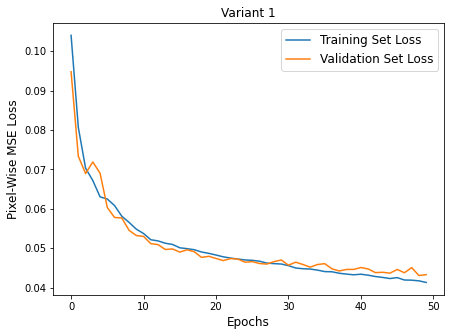

In [ ]:

train_losses = pickle.load(open(path_drive + "onehot_train_losses.pkl",'rb'))
val_losses = pickle.load(open(path_drive + "onehot_val_losses.pkl",'rb'))


#plotting losses


plt.figure(figsize=(7,5))
plt.plot(range(50), train_losses[:50], label = "Training Set Loss")
plt.plot(range(50), val_losses[:50], label = "Validation Set Loss")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Pixel-Wise MSE Loss", fontsize=12)
plt.title("Variant 1")
plt.legend(fontsize=12)


# Sample Output

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


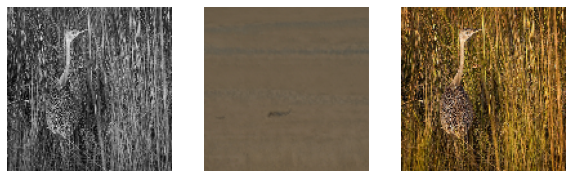

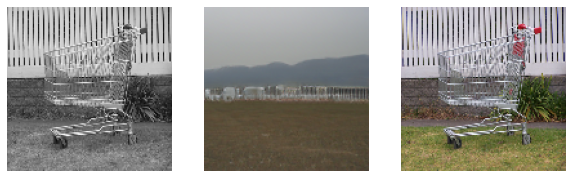

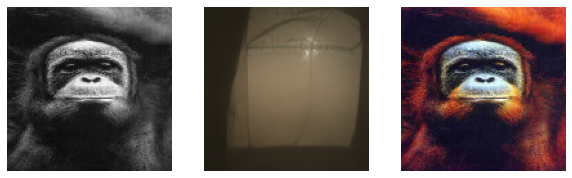

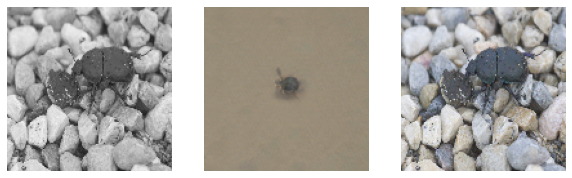

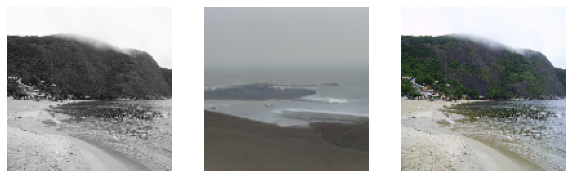

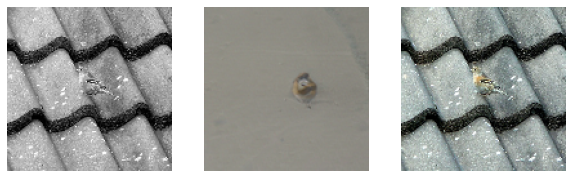

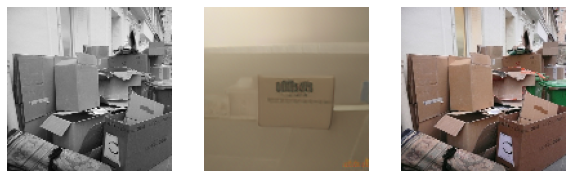

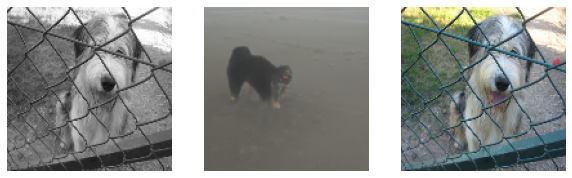

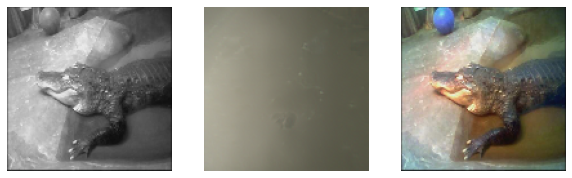

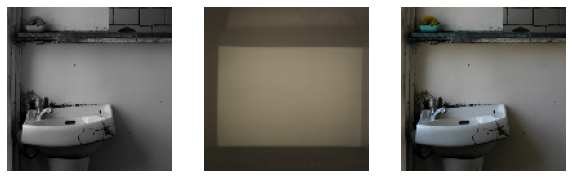

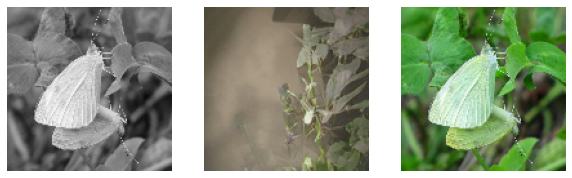

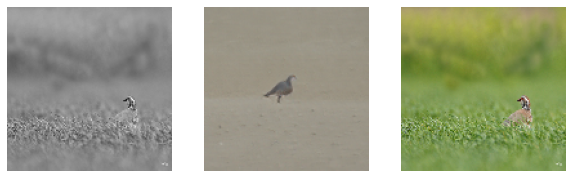

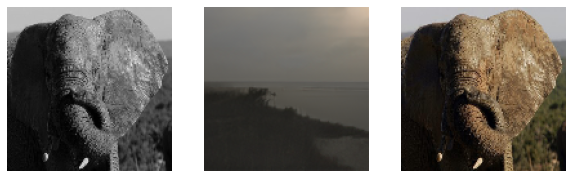

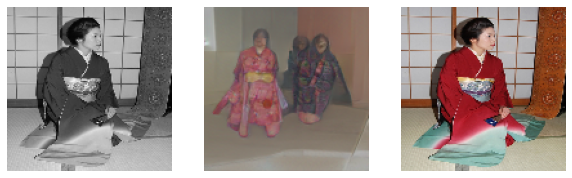

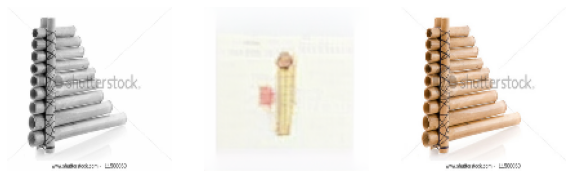

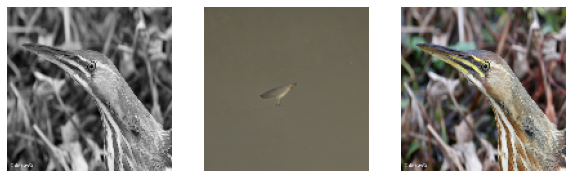

In [ ]:


val_dataloader = get_dataloader('5k', 128, 'test')

out = None


with torch.no_grad():
    g, c, gt = iter(val_dataloader).next()
    g = g.to(device)
    c = c.to(device)
    gt = gt.to(device)

    out, encoding, _ = colornet(g, truncation = 0.1, gt=gt)



for i in range(16):
    fig, ax = plt.subplots(1,3, figsize=(10,30))
    ax[0].imshow(g[i].detach().cpu().numpy().transpose(1,2,0))
    ax[0].axis("off")
    ax[1].imshow(out[i].detach().cpu().numpy().transpose(1,2,0))
    ax[1].axis("off")
    ax[2].imshow(c[i].detach().cpu().numpy().transpose(1,2,0))
    ax[2].axis("off")